# Import

In [61]:
import csv
import os
import pickle
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm

## Add configuration file

In [62]:
sys.path.append("/home/jovyan/core/config/")
sys.path.append("/home/jovyan/core/util/")
sys.path.append("../PlotFunction/lineplot/")
sys.path.append("../PlotFunction/config/")

In [63]:
from ALL import config
from line_plot_1 import line_plot_1
from line_plot_error_1 import line_plot_error_1
from line_plot_error_1_layout import layout
from util import *

## Set condition

In [64]:
tqdm.pandas()
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 50)

In [65]:
data_type = "AgNews"
vectorize_types = ["doc2vec", "sentenceBERT"]

# Read data

In [66]:
df = pd.read_csv(
    f"../../Preprocessing/data/{data_type}/master.csv", index_col=0
)

In [67]:
with open(f"../../Preprocessing/data/{data_type}/class.csv", mode="r") as f:
    reader = csv.reader(f)
    class_labels = [label for label in reader]

In [68]:
vector_dims = config["vectorize"]["doc2vec"]["dims"]
model_nums = config["clustering"]["gmm"]["max_model_num"]
vector_model_num = config["vectorize"]["doc2vec"]["max_model_num"]
normalization = "centralized"
covariance_types = ['spherical', 'diag', 'full']

In [69]:
stats_vals = ["mi"]

In [70]:
def get_stats_vals(
    data_type, vectorize_type, covariance_types, normalization, stats_vals
):
    # データ型定義
    stats = {
        stats_val: {
            covariance_type: {
                model_num: pd.DataFrame for model_num in range(model_nums)
            }
            for covariance_type in covariance_types
        }
        for stats_val in stats_vals
    }

    # データ取得
    for stats_val in stats_vals:
        for covariance_type in covariance_types:
            for model_num in range(model_nums):
                stats_path = f"../../Postprocessing/data/{data_type}/{vectorize_type}/GMM/stats/{normalization}/{covariance_type}/{model_num}.csv"
                df = pd.read_csv(stats_path, index_col=0)
                stats[stats_val][covariance_type][model_num] = df.loc[:, stats_val]
    return stats

In [71]:
stats = {
    vectorize_type: get_stats_vals(
        data_type, vectorize_type, covariance_types, normalization, stats_vals
    )
    for vectorize_type in vectorize_types
}

FileNotFoundError: [Errno 2] No such file or directory: '../../Postprocessing/data/AgNews/doc2vec/GMM/stats/centralized/spherical/0.csv'

In [ ]:
lda_mi = pd.read_csv(f"../../Postprocessing/data/{data_type}/LDA/mi.csv", index_col=0)

In [ ]:
describe_lda_mi, _ = get_describe(lda_mi, axis=0)

# Data shaping

In [ ]:
def make_stats_df(stats, covariance_types, stats_vals):
    stats_df = {
        stats_val: {covariance_type: pd.DataFrame() for covariance_type in covariance_types}
        for stats_val in stats_vals
    }

    for stats_val in stats_vals:
        for covariance_type in covariance_types:
            # model_numについて取得データstatsを結合
            stats_df[stats_val][covariance_type] = pd.concat(
                stats[stats_val][covariance_type], axis=1
            )
    return stats_df

In [ ]:
stats_df = {
    vectorize_type: make_stats_df(stats[vectorize_type], covariance_types, stats_vals)
    for vectorize_type in vectorize_types
}

In [72]:
def make_describe(stats_df, covariance_type, stats_vals):
    describe = {
        stats_val: {covariance_type: dict() for covariance_type in covariance_types}
        for stats_val in stats_vals
    }

    for stats_val in stats_vals:
        for covariance_type in covariance_types:
            describe[stats_val][covariance_type], describe_keys = get_describe(
                stats_df[stats_val][covariance_type], axis=1
            )
    return describe, describe_keys

In [51]:
describe = {vectorize_type: {} for vectorize_type in vectorize_types}
for vectorize_type in vectorize_types:
    _describe, describe_keys = make_describe(stats_df[vectorize_type], covariance_types, stats_vals)
    describe[vectorize_type] = _describe

In [53]:
def make_data(describe, covariance_types, stats_vals, describe_keys):
    data = {
        stats_val: {describe_key: pd.DataFrame() for describe_key in describe_keys}
        for stats_val in stats_vals
    }
    for stats_val in stats_vals:
        for describe_key in describe_keys:
            # covariance_typeについてデータを結合
            _data = {
                covariance_type: describe[stats_val][covariance_type][describe_key]
                for covariance_type in covariance_types
            }
            data[stats_val][describe_key] = pd.concat(_data, axis=1)
    return data

In [55]:
data = {
    vectorize_type: make_data(
        describe[vectorize_type], covariance_types, stats_vals, describe_keys
    )
    for vectorize_type in vectorize_types
}

In [58]:
error_low = {
    vectorize_type: data[vectorize_type]["mi"]["std"]
    for vectorize_type in vectorize_types
}
error_upper = {
    vectorize_type: data[vectorize_type]["mi"]["std"]
    for vectorize_type in vectorize_types
}
title = f"{data_type}    ({vectorize_type})"
xlabel = "埋め込み次元"
ylabel = "mi"
yticks = np.arange(0, 1.1, 0.1)
# path = fig_path

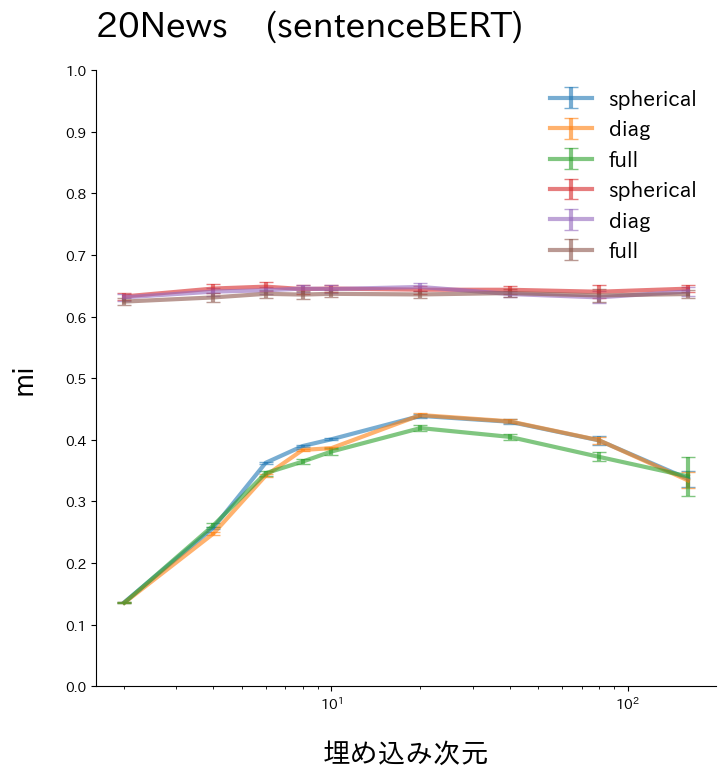

In [60]:
fig = plt.figure(**layout["figure"])
ax = fig.add_subplot(111)
fig_path = f"../data/figure/{data_type}/{vectorize_type}/GMM/stats/mi.pdf"
ax.set_xscale("log")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
for vectorize_type in vectorize_types:
    for column in data[vectorize_type]["mi"]["mean"].columns:
        ax.errorbar(
            x=data[vectorize_type]["mi"]["mean"].index.to_numpy(),
            y=data[vectorize_type]["mi"]["mean"].loc[:, column].to_numpy(),
            yerr=np.stack(
                [
                    error_low[vectorize_type].loc[:, column].to_numpy(),
                    error_upper[vectorize_type].loc[:, column].to_numpy(),
                ],
            ),
            label=column,
            **layout["plot"],
        )

# ax.axhline(
#     y=describe_lda_mi["mean"].to_numpy(), linestyle="dashed", color="gray", label="LDA"
# )

ax.set_title(title, **layout["title"])

ax.set_xlabel(xlabel, **layout["label"])
ax.set_ylabel(ylabel, **layout["label"])
ax.set_yticks(ticks=yticks, **layout["ticks"])
ax.legend(**layout["legend"])

fig.savefig(make_filepath(fig_path))

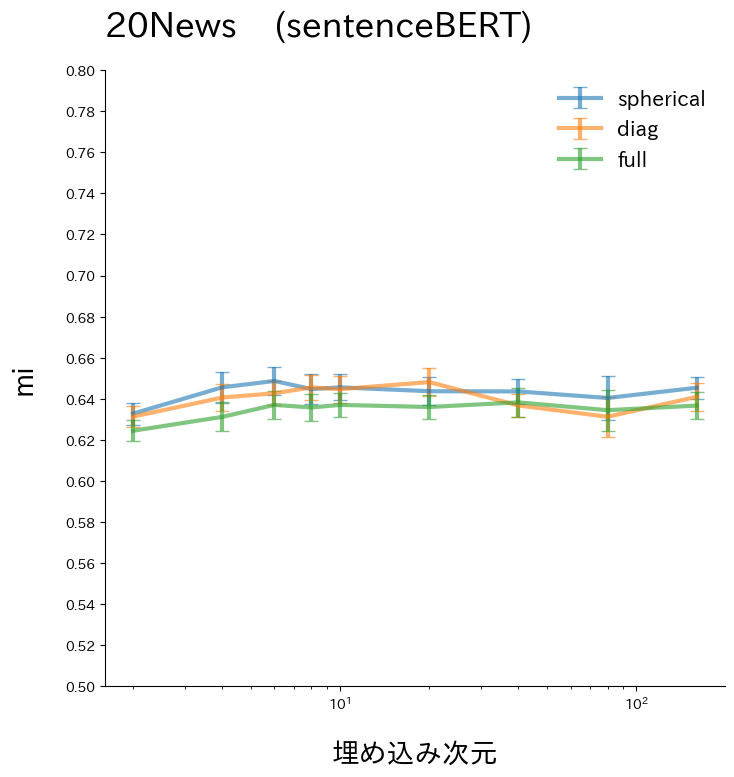

In [34]:
fig = plt.figure(**layout["figure"])
ax = fig.add_subplot(111)
fig_path = f"../data/figure/{data_type}/{vectorize_type}/GMM/stats/mi.pdf"
ax.set_xscale("log")
line_plot_error_1(
    data["mi"]["mean"],
    error_low=data["mi"]["std"],
    error_upper=data["mi"]["std"],
    fig=fig,
    ax=ax,
    layout=layout,
    title=f"{data_type}    ({vectorize_type})",
    xlabel="埋め込み次元",
    ylabel="mi",
    yticks=np.arange(0.5, 0.8, 0.02),
    path=fig_path,
)

# ax.axhline(
#     y=describe_lda_mi["mean"].to_numpy(), linestyle="dashed", color="gray"
# )